In [0]:
# 1. Définir les configurations avec vos informations d'identification
account_name = "projet2024"
account_key = "lgJb6ipPO6g8oYsxrl9FonRqMgMBzBIzNI+wwUuiqon7f90iOsN+QEzQkIqyBTOhfY6aOMcVIZv0+AStPrw9Ng=="
file_system_name = "datawarehouse"

configs = {
    f"fs.azure.account.key.{account_name}.blob.core.windows.net": account_key
}

# Vérifier si le répertoire est déjà monté
mount_point = "/mnt/adls"
if any(mount.mountPoint == mount_point for mount in dbutils.fs.mounts()):
    dbutils.fs.unmount(mount_point)

# 2. Monter le conteneur ADLS dans Databricks
dbutils.fs.mount(
    source = f"wasbs://{file_system_name}@{account_name}.blob.core.windows.net/",
    mount_point = mount_point,
    extra_configs = configs
)

# 4. Nettoyer les données avec Pandas
import pandas as pd
import os

# Définir le nom du fichier et le chemin
file_name = "APIProcessedData.csv"
local_file_path = "/dbfs" + f"{mount_point}/processed_data/{file_name}"  # Convertir le chemin DBFS pour un accès local en Pandas

# Vérifier si le fichier existe
if not os.path.isfile(local_file_path):
    raise FileNotFoundError(f"Le fichier {local_file_path} n'a pas été trouvé.")


/mnt/adls has been unmounted.


In [0]:
if not os.path.isfile(local_file_path):
    raise FileNotFoundError(f"Le fichier {local_file_path} n'a pas été trouvé.")

# Lire le fichier CSV avec Pandas
df_jobs = pd.read_csv(
    local_file_path,
    delimiter=",",               # Délimiteur utilisé dans le CSV,           
    engine='python',             # Utiliser l'engine Python pour plus de flexibilité avec les délimiteurs
    encoding='utf-8',            # Encodage du fichier (ajustez si nécessaire)
    on_bad_lines='warn'          # Alerter sur les lignes mal formées
)

In [0]:

# Afficher les premières lignes pour vérifier le contenu
print("Premières lignes du DataFrame :")
df_jobs.head()

Premières lignes du DataFrame :


,id,intitule,description,dateCreation,dateActualisation,romeCode,romeLibelle,appellationlibelle,typeContrat,typeContratLibelle,natureContrat,experienceExige,experienceLibelle,dureeTravailLibelle,dureeTravailLibelleConverti,qualificationCode,qualificationLibelle,codeNAF,secteurActivite,secteurActiviteLibelle,lieuTravail.libelle,lieuTravail.latitude,lieuTravail.longitude,lieuTravail.codePostal,lieuTravail.commune,entreprise.nom,salaire.libelle,contact.coordonnees1,origineOffre.origine,origineOffre.urlOrigine,salaire.complement1,salaire.complement2,deplacementCode,contact.nom,salaire_per_year,Contrat
0,179WDKP,Façadier / Enduiseur (H/F),"En activité depuis une vingtaine d'année, notr...",2024-08-23T04:57:33.476Z,2024-08-23T04:57:33.698Z,F1611,Façadier / Façadière,Façadier-enduiseur / Façadière-enduiseuse,MIS,Intérim - 1 Mois,Contrat travail,E,1,35H,Temps plein,3.0,"Ouvrier qualifié (P1,P2)",78.20Z,78.0,Activités des agences de travail temporaire,86 - Ormes,46.963733,0.625443,86220,86183,PARTNAIRE NOUVELLE AQUITAINE NORD,Horaire de 11.65 Euros à 13.0 Euros sur 12.0 mois,http://app.mytalentplug.com/description-offre....,1.0,https://candidat.francetravail.fr/offres/reche...,0,0,0.0,0,24232.0,Intérim
1,179WDKN,CANALISATEUR (H/F),"Votre agence Partnaire Avignon, avec son équip...",2024-08-23T04:57:23.593Z,2024-08-23T04:57:23.799Z,F1705,Canalisateur / Canalisatrice,Poseur / Poseuse de canalisations,MIS,Intérim - 2 Mois,Contrat travail,E,2,35H,Temps plein,3.0,"Ouvrier qualifié (P1,P2)",78.20Z,78.0,Activités des agences de travail temporaire,84 - Thor,43.921969,4.995674,84250,84132,PARTNAIRE,Horaire de 12.0 Euros à 12.0 Euros sur 12.0 mois,http://app.mytalentplug.com/description-offre....,1.0,https://candidat.francetravail.fr/offres/reche...,0,0,0.0,0,24960.0,Intérim
2,179WDKM,Chef de partie LE/M,"Aquila Rh Cannes, acteur du recrutement en CDD...",2024-08-23T04:57:20.471Z,2024-08-23T04:57:20.733Z,A1102,Conducteur / Conductrice d'engins d'exploitati...,Opérateur / Opératrice d'abatteuse,MIS,Intérim - 3 Mois,Contrat travail,D,0,35H,Temps plein,6.0,Employé qualifié,78.20Z,78.0,Activités des agences de travail temporaire,06 - Cannes,43.555468,7.004585,6150,6029,L.A.B.EILLE,Mensuel de 2900.0 Euros à 3300.0 Euros sur 12....,http://app.mytalentplug.com/redirection.aspx?o...,1.0,https://candidat.francetravail.fr/offres/reche...,0,0,0.0,0,34800.0,Intérim
3,179WDKL,Ouvrier / Ouvrière d'abattoir (H/F),"Réceptionner et enregistrer les animaux, procé...",2024-08-23T04:51:21.653Z,2024-08-23T04:51:22.097Z,H2101,Ouvrier / Ouvrière d'abattoir,Ouvrier / Ouvrière d'abattoir,CDD,CDD - 4 Mois,Contrat travail,D,0,35H,Temps plein,5.0,Employé non qualifié,10.11Z,10.0,Transformation et conservation de la viande de...,973 - REMIRE MONTJOLY,4.892346,-52.278099,97354,97309,ABATTOIR TERRITORIAL,Mensuel de 1800.0 Euros à 1900.0 Euros sur 12....,0,1.0,https://candidat.francetravail.fr/offres/reche...,Primes,Chèque repas,0.0,0,21600.0,CDD
4,179WDKH,Bancheur coffreur (H/F),"Votre agence Partnaire Orange, avec son équipe...",2024-08-23T04:47:37.469Z,2024-08-23T04:47:37.726Z,F1701,Coffreur / Coffreuse,Coffreur bancheur / Coffreuse bancheuse,MIS,Intérim - 3 Mois,Contrat travail,E,1,35H,Temps plein,6.0,Employé qualifié,78.20Z,78.0,Activités des agences de travail temporaire,84 - Orange,44.132797,4.820804,84100,84087,PARTENAIRE ORANGE,Annuel de 21204.0 Euros à 22000.0 Euros sur 12...,http://app.mytalentplug.com/description-offre....,1.0,https://candidat.francetravail.fr/offres/reche...,0,0,0.0,0,21204.0,Intérim


In [0]:
# Définir le nom du fichier et le chemin
file_name2 = "DiplomeFE.csv"
local_file_path2= "/dbfs" + f"{mount_point}/processed_data/{file_name2}"  # Convertir le chemin DBFS pour un accès local en Pandas

# Vérifier si le fichier existe
if not os.path.isfile(local_file_path2):
    raise FileNotFoundError(f"Le fichier {local_file_path2} n'a pas été trouvé.")


In [0]:
df_diplomas = pd.read_csv(local_file_path2, sep=',', engine='python', encoding='utf-8', on_bad_lines='warn')
df_diplomas.head()

,session,eta_nom,acad_lib,acad_reg_lib,mention,parcours,alternance,modalite_enseignement,lieux_formation,disci_master,disci_lib,secteur_disci_lib,n_accept,n_accept_femme,uo_lib_actuel
0,2023,Université Paris Cité,Paris,Île-de-France,physique fondamentale et applications,"Ingenierie Physique des Energies - (master, s...",False,"INITIALE,CONTINUE,HYBRIDE",UFR Physique – Campus Grands Moulins - PARIS (...,Sc. fondamentales et appliquées (dont S.T.A.P.S.),Sciences fondamentales et applications,Physique,1,0,Université Paris Cité
1,2023,Université Paris Cité,Paris,Île-de-France,physique fondamentale et applications,"Physique fondamentale - (master, sciences, ph...",False,"INITIALE,HYBRIDE",UFR Physique – Campus Grands Moulins - PARIS (...,Sc. fondamentales et appliquées (dont S.T.A.P.S.),Sciences fondamentales et applications,Physique,34,14,Université Paris Cité
2,2023,Université Paris Cité,Paris,Île-de-France,genetique,Unknown,False,"INITIALE,CONTINUE,HYBRIDE","UFR SDV - PARIS (75),Université Paris Cité - P...",Sc. fondamentales et appliquées (dont S.T.A.P.S.),"Sciences de la vie, de la terre et de l'univers","Sciences de la vie, biologie, santé",40,27,Université Paris Cité
3,2023,Université Sorbonne Paris Nord,Créteil,Île-de-France,droit,M1 Droit Social et Relations Sociales dans les...,False,"INITIALE,HYBRIDE",Université Sorbonne Paris Nord - VILLETANEUSE ...,Droit et sc. politiques,"Droit, sciences politiques",Sciences juridiques,17,16,Université Sorbonne Paris Nord
4,2023,Université Sorbonne Paris Nord,Créteil,Île-de-France,droit,M1 Droit Privé Général : M2 Immobilier,False,"INITIALE,HYBRIDE",Université Sorbonne Paris Nord - VILLETANEUSE ...,Droit et sc. politiques,"Droit, sciences politiques",Sciences juridiques,21,19,Université Sorbonne Paris Nord


In [0]:
!pip install fuzzywuzzy

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
# Extract the city/town name by splitting on the hyphen and taking the part after it
df_jobs['city_name'] = df_jobs['lieuTravail.libelle'].apply(lambda x: x.split(' - ')[1] if ' - ' in x else x)

# Now let's try to match this city name with the academic regions in df_diplomas
from fuzzywuzzy import process

def match_city_to_acad(city, acad_list):
    match, score = process.extractOne(city, acad_list)
    return match if score > 80 else None  # Only keep matches with a high confidence score

df_jobs['matched_acad'] = df_jobs['city_name'].apply(lambda x: match_city_to_acad(x, df_diplomas['acad_lib'].dropna().unique()))

# Merge based on this new matching
merged_df = pd.merge(df_jobs, df_diplomas, how='inner', left_on='matched_acad', right_on='acad_lib')

# Inspect the merged data
print(merged_df.head())


/local_disk0/.ephemeral_nfs/envs/pythonEnv-01b89130-e9ea-4425-8602-16eb0b025a63/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


        id                    intitule  ... n_accept_femme uo_lib_actuel
0  179WDKP  Façadier / Enduiseur (H/F)  ...              0           NaN
1  179WDKP  Façadier / Enduiseur (H/F)  ...              3           NaN
2  179WDKN          CANALISATEUR (H/F)  ...              0           NaN
3  179WDKN          CANALISATEUR (H/F)  ...              3           NaN
4  179WDKM         Chef de partie LE/M  ...              0           NaN

[5 rows x 53 columns]


In [0]:
# Checking for missing values in the merged dataframe
missing_data = merged_df.isnull().sum()

# Display columns with missing data
print(missing_data[missing_data > 0])

# Drop rows where critical data might be missing, or fill missing values if appropriate
cleaned_df = merged_df.dropna(subset=['uo_lib_actuel'])  # Example for dropping rows with missing 'uo_lib_actuel'
print(cleaned_df.head())


matched_acad             282
eta_nom                  282
acad_lib                 282
acad_reg_lib             282
modalite_enseignement      1
uo_lib_actuel            282
dtype: int64
          id        intitule  ... n_accept_femme           uo_lib_actuel
282  179WDJP  Réceptionniste  ...             57  Université Côte d'Azur
283  179WDJP  Réceptionniste  ...              1  Université Côte d'Azur
284  179WDJP  Réceptionniste  ...              3  Université Côte d'Azur
285  179WDJP  Réceptionniste  ...              3  Université Côte d'Azur
286  179WDJP  Réceptionniste  ...              7  Université Côte d'Azur

[5 rows x 53 columns]


In [0]:
# Check how well the matching worked by inspecting the original city names and their matched academic regions
validation_sample = cleaned_df[['city_name', 'matched_acad', 'acad_lib']].head(20)
print(validation_sample)


    city_name matched_acad acad_lib
282      Nice         Nice     Nice
283      Nice         Nice     Nice
284      Nice         Nice     Nice
285      Nice         Nice     Nice
286      Nice         Nice     Nice
287      Nice         Nice     Nice
288      Nice         Nice     Nice
289      Nice         Nice     Nice
290      Nice         Nice     Nice
291      Nice         Nice     Nice
292      Nice         Nice     Nice
293      Nice         Nice     Nice
294      Nice         Nice     Nice
295      Nice         Nice     Nice
296      Nice         Nice     Nice
297      Nice         Nice     Nice
298      Nice         Nice     Nice
299      Nice         Nice     Nice
300      Nice         Nice     Nice
301      Nice         Nice     Nice


# Mapping pour avoir le diplome dans df_jobs

In [0]:
import numpy as np

# Step 1: Define a keyword-to-diploma mapping with French names
keyword_to_diploma = {
    # Ingénierie et Technologie
    'maintenance': 'Ingénierie et Technologie',
    'électrique': 'Ingénierie et Technologie',
    'mécanique': 'Ingénierie et Technologie',
    'régleur': 'Ingénierie et Technologie',
    'plombier': 'Ingénierie et Technologie',
    'menuisier': 'Ingénierie et Technologie',
    'soudure': 'Ingénierie et Technologie',
    'technicien': 'Ingénierie et Technologie',

    # Gestion et Management
    'gestionnaire': 'Gestion et Management',
    'commerce': 'Gestion et Management',
    'marketing': 'Gestion et Management',
    'logistique': 'Gestion et Management',
    'comptable': 'Gestion et Management',
    'assurance': 'Gestion et Management',

    # Sciences Sociales et Humanités
    'téléconseiller': 'Sciences Sociales et Humanités',
    'communication': 'Sciences Sociales et Humanités',
    'ressources humaines': 'Sciences Sociales et Humanités',
    'social': 'Sciences Sociales et Humanités',

    # Santé et Médecine
    'infirmier': 'Santé et Médecine',
    'santé': 'Santé et Médecine',
    'pharmacie': 'Santé et Médecine',

    # Autres domaines (ajoutez-en plus si nécessaire)
    'agriculture': 'Sciences de l\'Environnement',
    'environnement': 'Sciences de l\'Environnement',
    'informatique': 'Technologies de l\'Information',
    'urbanisme': 'Urbanisme et Architecture',
    'architecture': 'Urbanisme et Architecture',
}

# Step 2: Define a function to assign diploma based on description
def assign_diploma(description):
    description = description.lower()  # Convert to lower case for matching
    for keyword, diploma in keyword_to_diploma.items():
        if keyword in description:
            return diploma
    return 'Autre'  # Default category if no keyword matches

# Step 3: Apply the function to the job descriptions
df_jobs['diploma_needed'] = df_jobs['description'].apply(assign_diploma)

# Step 4: Inspect the updated DataFrame
print(df_jobs[['intitule', 'diploma_needed', 'description']].head(20))


                                  intitule  ...                                        description
0               Façadier / Enduiseur (H/F)  ...  En activité depuis une vingtaine d'année, notr...
1                       CANALISATEUR (H/F)  ...  Votre agence Partnaire Avignon, avec son équip...
2                      Chef de partie LE/M  ...  Aquila Rh Cannes, acteur du recrutement en CDD...
3      Ouvrier / Ouvrière d'abattoir (H/F)  ...  Réceptionner et enregistrer les animaux, procé...
4                  Bancheur coffreur (H/F)  ...  Votre agence Partnaire Orange, avec son équipe...
5                  Assistant manager (H/F)  ...  Votre agence Partnaire Bron recrute  un adjoin...
6                       Assistant rh (H/F)  ...  Votre agence Partnaire IPC du 9e arrondissemen...
7                            Pontier (H/F)  ...  Notre client, est le 2e producteur de papier e...
8                    Serveur de restaurant  ...  Aquila RH Nice, acteur du recrutement en CDD r...
9         

# Visuels

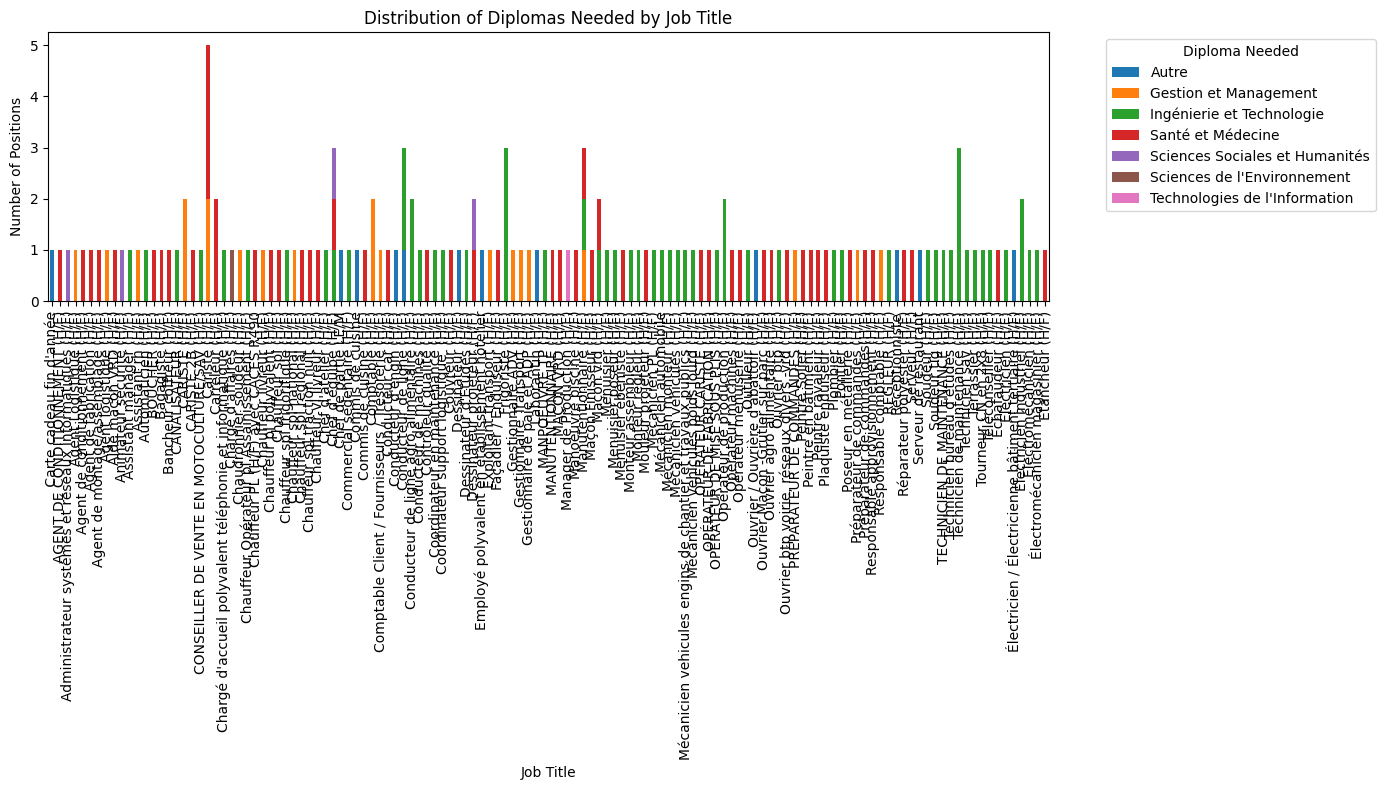

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each diploma needed per job title
diploma_counts = df_jobs.groupby('intitule')['diploma_needed'].value_counts().unstack().fillna(0)

# Plot the data
diploma_counts.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Distribution of Diplomas Needed by Job Title')
plt.xlabel('Job Title')
plt.ylabel('Number of Positions')
plt.legend(title='Diploma Needed', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


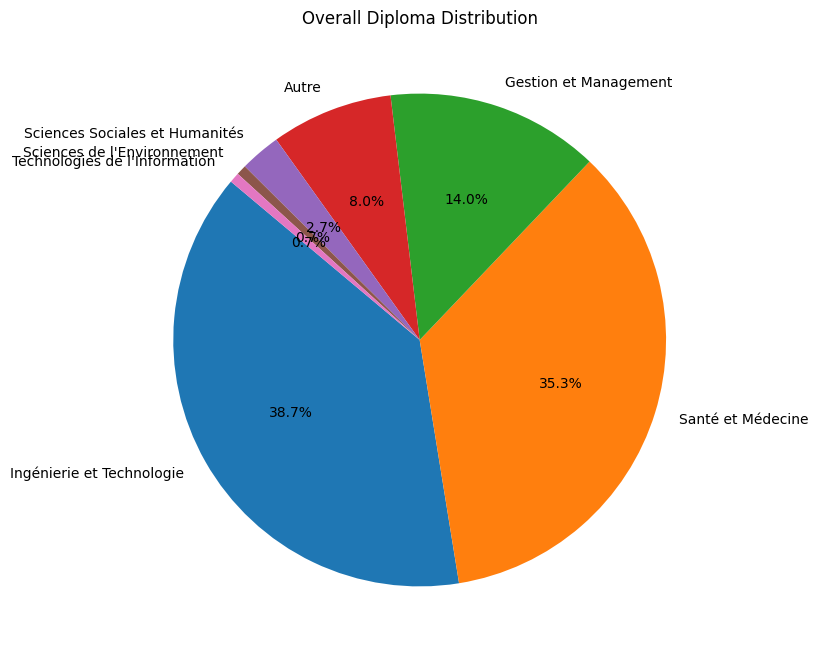

In [0]:
# Count the overall occurrences of each diploma needed
overall_diploma_distribution = df_jobs['diploma_needed'].value_counts()

# Plot the data as a pie chart
plt.figure(figsize=(8, 8))
overall_diploma_distribution.plot.pie(autopct='%1.1f%%', startangle=140)
plt.title('Overall Diploma Distribution')
plt.ylabel('')  # Hide y-label
plt.show()


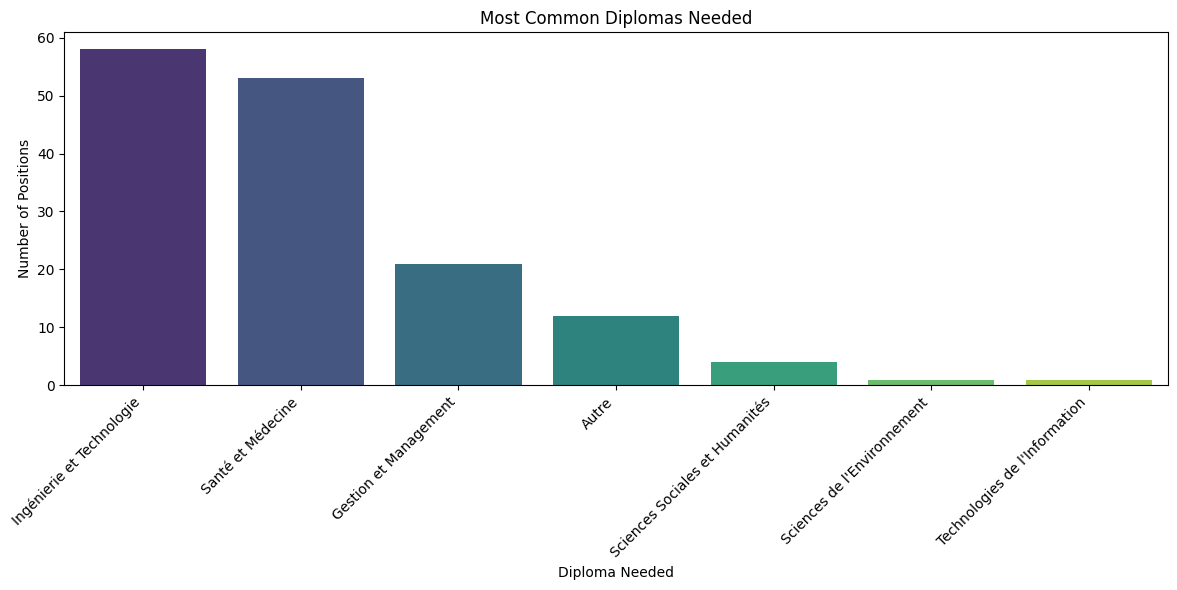

In [0]:
# Count the occurrences of each diploma needed
diploma_distribution = df_jobs['diploma_needed'].value_counts()

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x=diploma_distribution.index, y=diploma_distribution.values, palette="viridis")
plt.title('Most Common Diplomas Needed')
plt.xlabel('Diploma Needed')
plt.ylabel('Number of Positions')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


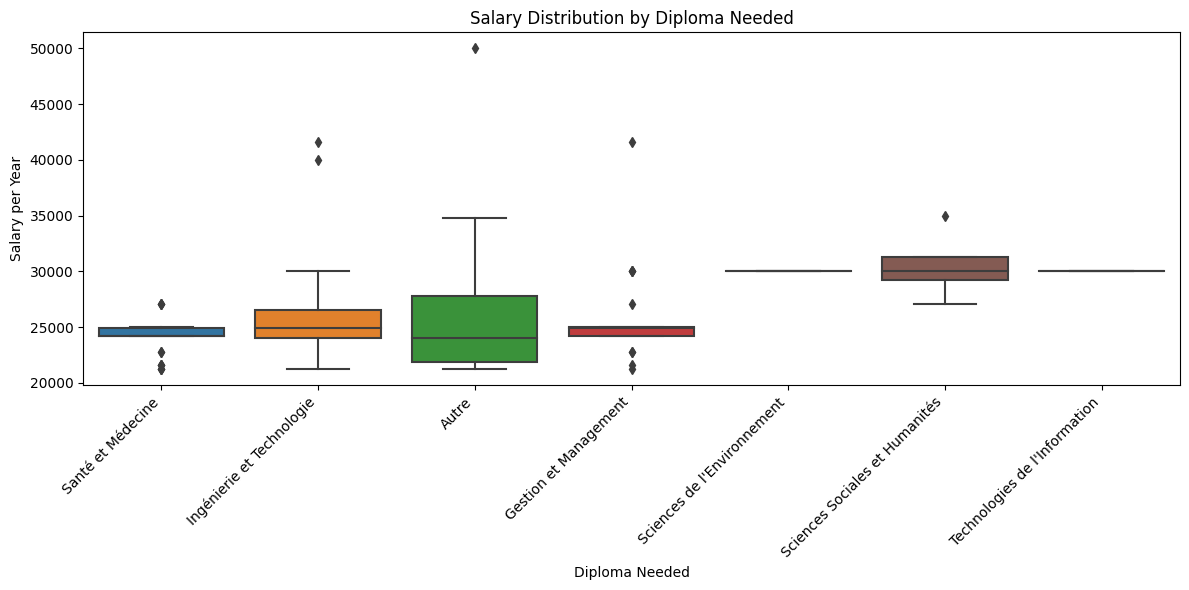

In [0]:
# First, ensure that the 'salary_per_year' column exists in df_jobs
if 'salaire_per_year' in df_jobs.columns:
    # If the column exists, proceed with plotting
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='diploma_needed', y='salaire_per_year', data=df_jobs)
    plt.title('Salary Distribution by Diploma Needed')
    plt.xlabel('Diploma Needed')
    plt.ylabel('Salary per Year')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    # If the column does not exist, print an error message
    print("Error: 'salary_per_year' column does not exist in df_jobs.")

In [0]:
df_jobs.head()


,id,intitule,description,dateCreation,dateActualisation,romeCode,romeLibelle,appellationlibelle,typeContrat,typeContratLibelle,natureContrat,experienceExige,experienceLibelle,dureeTravailLibelle,dureeTravailLibelleConverti,qualificationCode,qualificationLibelle,codeNAF,secteurActivite,secteurActiviteLibelle,lieuTravail.libelle,lieuTravail.latitude,lieuTravail.longitude,lieuTravail.codePostal,lieuTravail.commune,entreprise.nom,salaire.libelle,contact.coordonnees1,origineOffre.origine,origineOffre.urlOrigine,salaire.complement1,salaire.complement2,deplacementCode,contact.nom,salaire_per_year,Contrat,city_name,matched_acad,diploma_needed
0,179WDKP,Façadier / Enduiseur (H/F),"En activité depuis une vingtaine d'année, notr...",2024-08-23T04:57:33.476Z,2024-08-23T04:57:33.698Z,F1611,Façadier / Façadière,Façadier-enduiseur / Façadière-enduiseuse,MIS,Intérim - 1 Mois,Contrat travail,E,1,35H,Temps plein,3.0,"Ouvrier qualifié (P1,P2)",78.20Z,78.0,Activités des agences de travail temporaire,86 - Ormes,46.963733,0.625443,86220,86183,PARTNAIRE NOUVELLE AQUITAINE NORD,Horaire de 11.65 Euros à 13.0 Euros sur 12.0 mois,http://app.mytalentplug.com/description-offre....,1.0,https://candidat.francetravail.fr/offres/reche...,0,0,0.0,0,24232.0,Intérim,Ormes,None,Santé et Médecine
1,179WDKN,CANALISATEUR (H/F),"Votre agence Partnaire Avignon, avec son équip...",2024-08-23T04:57:23.593Z,2024-08-23T04:57:23.799Z,F1705,Canalisateur / Canalisatrice,Poseur / Poseuse de canalisations,MIS,Intérim - 2 Mois,Contrat travail,E,2,35H,Temps plein,3.0,"Ouvrier qualifié (P1,P2)",78.20Z,78.0,Activités des agences de travail temporaire,84 - Thor,43.921969,4.995674,84250,84132,PARTNAIRE,Horaire de 12.0 Euros à 12.0 Euros sur 12.0 mois,http://app.mytalentplug.com/description-offre....,1.0,https://candidat.francetravail.fr/offres/reche...,0,0,0.0,0,24960.0,Intérim,Thor,None,Ingénierie et Technologie
2,179WDKM,Chef de partie LE/M,"Aquila Rh Cannes, acteur du recrutement en CDD...",2024-08-23T04:57:20.471Z,2024-08-23T04:57:20.733Z,A1102,Conducteur / Conductrice d'engins d'exploitati...,Opérateur / Opératrice d'abatteuse,MIS,Intérim - 3 Mois,Contrat travail,D,0,35H,Temps plein,6.0,Employé qualifié,78.20Z,78.0,Activités des agences de travail temporaire,06 - Cannes,43.555468,7.004585,6150,6029,L.A.B.EILLE,Mensuel de 2900.0 Euros à 3300.0 Euros sur 12....,http://app.mytalentplug.com/redirection.aspx?o...,1.0,https://candidat.francetravail.fr/offres/reche...,0,0,0.0,0,34800.0,Intérim,Cannes,None,Autre
3,179WDKL,Ouvrier / Ouvrière d'abattoir (H/F),"Réceptionner et enregistrer les animaux, procé...",2024-08-23T04:51:21.653Z,2024-08-23T04:51:22.097Z,H2101,Ouvrier / Ouvrière d'abattoir,Ouvrier / Ouvrière d'abattoir,CDD,CDD - 4 Mois,Contrat travail,D,0,35H,Temps plein,5.0,Employé non qualifié,10.11Z,10.0,Transformation et conservation de la viande de...,973 - REMIRE MONTJOLY,4.892346,-52.278099,97354,97309,ABATTOIR TERRITORIAL,Mensuel de 1800.0 Euros à 1900.0 Euros sur 12....,0,1.0,https://candidat.francetravail.fr/offres/reche...,Primes,Chèque repas,0.0,0,21600.0,CDD,REMIRE MONTJOLY,None,Autre
4,179WDKH,Bancheur coffreur (H/F),"Votre agence Partnaire Orange, avec son équipe...",2024-08-23T04:47:37.469Z,2024-08-23T04:47:37.726Z,F1701,Coffreur / Coffreuse,Coffreur bancheur / Coffreuse bancheuse,MIS,Intérim - 3 Mois,Contrat travail,E,1,35H,Temps plein,6.0,Employé qualifié,78.20Z,78.0,Activités des agences de travail temporaire,84 - Orange,44.132797,4.820804,84100,84087,PARTENAIRE ORANGE,Annuel de 21204.0 Euros à 22000.0 Euros sur 12...,http://app.mytalentplug.com/description-offre....,1.0,https://candidat.francetravail.fr/offres/reche...,0,0,0.0,0,21204.0,Intérim,Orange,None,Santé et Médecine


# Pour les analyses des diplomes

In [0]:
df_diplomas.head()


,session,eta_nom,acad_lib,acad_reg_lib,mention,parcours,alternance,modalite_enseignement,lieux_formation,disci_master,disci_lib,secteur_disci_lib,n_accept,n_accept_femme,uo_lib_actuel
0,2023,Université Paris Cité,Paris,Île-de-France,physique fondamentale et applications,"Ingenierie Physique des Energies - (master, s...",False,"INITIALE,CONTINUE,HYBRIDE",UFR Physique – Campus Grands Moulins - PARIS (...,Sc. fondamentales et appliquées (dont S.T.A.P.S.),Sciences fondamentales et applications,Physique,1,0,Université Paris Cité
1,2023,Université Paris Cité,Paris,Île-de-France,physique fondamentale et applications,"Physique fondamentale - (master, sciences, ph...",False,"INITIALE,HYBRIDE",UFR Physique – Campus Grands Moulins - PARIS (...,Sc. fondamentales et appliquées (dont S.T.A.P.S.),Sciences fondamentales et applications,Physique,34,14,Université Paris Cité
2,2023,Université Paris Cité,Paris,Île-de-France,genetique,Unknown,False,"INITIALE,CONTINUE,HYBRIDE","UFR SDV - PARIS (75),Université Paris Cité - P...",Sc. fondamentales et appliquées (dont S.T.A.P.S.),"Sciences de la vie, de la terre et de l'univers","Sciences de la vie, biologie, santé",40,27,Université Paris Cité
3,2023,Université Sorbonne Paris Nord,Créteil,Île-de-France,droit,M1 Droit Social et Relations Sociales dans les...,False,"INITIALE,HYBRIDE",Université Sorbonne Paris Nord - VILLETANEUSE ...,Droit et sc. politiques,"Droit, sciences politiques",Sciences juridiques,17,16,Université Sorbonne Paris Nord
4,2023,Université Sorbonne Paris Nord,Créteil,Île-de-France,droit,M1 Droit Privé Général : M2 Immobilier,False,"INITIALE,HYBRIDE",Université Sorbonne Paris Nord - VILLETANEUSE ...,Droit et sc. politiques,"Droit, sciences politiques",Sciences juridiques,21,19,Université Sorbonne Paris Nord


# Mapping to add diplome in df_diplomas

In [0]:
# Step 1: Define a mapping from mention or disci_lib to diploma_needed categories
mention_to_diploma = {
    # Ingénierie et Technologie
    'physique': 'Ingénierie et Technologie',
    'mécanique': 'Ingénierie et Technologie',
    'génie civil': 'Ingénierie et Technologie',
    'électronique': 'Ingénierie et Technologie',
    'informatique': 'Technologies de l\'Information',
    'sciences des matériaux': 'Ingénierie et Technologie',
    
    # Gestion et Management
    'économie': 'Gestion et Management',
    'gestion': 'Gestion et Management',
    'sciences de gestion': 'Gestion et Management',
    'management': 'Gestion et Management',
    'comptabilité': 'Gestion et Management',
    'droit': 'Gestion et Management',
    'sciences économiques': 'Gestion et Management',

    # Sciences Sociales et Humanités
    'sciences sociales': 'Sciences Sociales et Humanités',
    'psychologie': 'Sciences Sociales et Humanités',
    'sciences du langage': 'Sciences Sociales et Humanités',
    'sciences de la communication': 'Sciences Sociales et Humanités',
    'sociologie': 'Sciences Sociales et Humanités',
    'histoire': 'Sciences Sociales et Humanités',
    'philosophie': 'Sciences Sociales et Humanités',

    # Santé et Médecine
    'sciences de la vie, biologie, santé': 'Santé et Médecine',
    'sciences du médicament': 'Santé et Médecine',
    'pharmacie': 'Santé et Médecine',
    'infirmier': 'Santé et Médecine',

    # Sciences de l'Environnement
    'sciences de l\'environnement': 'Sciences de l\'Environnement',
    'écologie': 'Sciences de l\'Environnement',
    'géographie': 'Sciences de l\'Environnement',
    
    # Autres domaines
    'arts': 'Arts et Littérature',
    'musique': 'Arts et Littérature',
    'cinéma': 'Arts et Littérature',
    'architecture': 'Urbanisme et Architecture',
    'urbanisme': 'Urbanisme et Architecture',
    'sciences humaines': 'Sciences Sociales et Humanités',
    # Add more mappings as needed...
}

# Step 2: Apply this mapping to df_diplomas to create the diploma_needed column
df_diplomas['diploma_needed'] = df_diplomas['mention'].map(mention_to_diploma)

# Step 3: Handle any diplomas that were not mapped
df_diplomas['diploma_needed'] = df_diplomas['diploma_needed'].fillna('Autre')

# Step 4: Inspect the updated DataFrame
print(df_diplomas[['mention', 'diploma_needed']].head(20))


                                              mention                  diploma_needed
0               physique fondamentale et applications                           Autre
1               physique fondamentale et applications                           Autre
2                                           genetique                           Autre
3                                               droit           Gestion et Management
4                                               droit           Gestion et Management
5                                               droit           Gestion et Management
6                                               droit           Gestion et Management
7                                               droit           Gestion et Management
8                                               droit           Gestion et Management
9                 biologie integrative et physiologie                           Autre
10  sciences de la terre et des planetes, environn... 

In [0]:
df_diplomas.head()

,session,eta_nom,acad_lib,acad_reg_lib,mention,parcours,alternance,modalite_enseignement,lieux_formation,disci_master,disci_lib,secteur_disci_lib,n_accept,n_accept_femme,uo_lib_actuel,diploma_needed
0,2023,Université Paris Cité,Paris,Île-de-France,physique fondamentale et applications,"Ingenierie Physique des Energies - (master, s...",False,"INITIALE,CONTINUE,HYBRIDE",UFR Physique – Campus Grands Moulins - PARIS (...,Sc. fondamentales et appliquées (dont S.T.A.P.S.),Sciences fondamentales et applications,Physique,1,0,Université Paris Cité,Autre
1,2023,Université Paris Cité,Paris,Île-de-France,physique fondamentale et applications,"Physique fondamentale - (master, sciences, ph...",False,"INITIALE,HYBRIDE",UFR Physique – Campus Grands Moulins - PARIS (...,Sc. fondamentales et appliquées (dont S.T.A.P.S.),Sciences fondamentales et applications,Physique,34,14,Université Paris Cité,Autre
2,2023,Université Paris Cité,Paris,Île-de-France,genetique,Unknown,False,"INITIALE,CONTINUE,HYBRIDE","UFR SDV - PARIS (75),Université Paris Cité - P...",Sc. fondamentales et appliquées (dont S.T.A.P.S.),"Sciences de la vie, de la terre et de l'univers","Sciences de la vie, biologie, santé",40,27,Université Paris Cité,Autre
3,2023,Université Sorbonne Paris Nord,Créteil,Île-de-France,droit,M1 Droit Social et Relations Sociales dans les...,False,"INITIALE,HYBRIDE",Université Sorbonne Paris Nord - VILLETANEUSE ...,Droit et sc. politiques,"Droit, sciences politiques",Sciences juridiques,17,16,Université Sorbonne Paris Nord,Gestion et Management
4,2023,Université Sorbonne Paris Nord,Créteil,Île-de-France,droit,M1 Droit Privé Général : M2 Immobilier,False,"INITIALE,HYBRIDE",Université Sorbonne Paris Nord - VILLETANEUSE ...,Droit et sc. politiques,"Droit, sciences politiques",Sciences juridiques,21,19,Université Sorbonne Paris Nord,Gestion et Management


# Sauvegarder les données dans un csv

In [0]:
container_name = "datawarehouse"
mount_point = "/mnt/datawarehouse"  # This is where the container will be mounted in Databricks

# Configuration settings for mounting the container
configs = {
    f"fs.azure.account.key.{account_name}.blob.core.windows.net": account_key
}

# Unmount the directory if it is already mounted
if any(mount.mountPoint == mount_point for mount in dbutils.fs.mounts()):
    dbutils.fs.unmount(mount_point)

# Mount the container to Databricks
dbutils.fs.mount(
    source = f"wasbs://{container_name}@{account_name}.blob.core.windows.net/",
    mount_point = mount_point,
    extra_configs = configs
)

print(f"{container_name} is mounted to {mount_point}")


# Step 1: Define the mount point and directory path using dbfs protocol
directory_path = "/dbfs/mnt/datawarehouse/processed_data"

# Step 2: Re-create the directory in Databricks (to ensure path existence)
dbutils.fs.mkdirs(directory_path)
print(f"Directory {directory_path} created or already exists.")

# Step 3: Verify the directory by listing the contents of the parent directory
display(dbutils.fs.ls("/mnt/datawarehouse"))

# Step 4: Define the full output path for the CSV file
output_file_path = f"{directory_path}/JobOffersPBI.csv"
output_file_path2 = f"{directory_path}/DiplomasPBI.csv"
# Step 5: Save the DataFrame as a CSV file in the created directory
df_jobs.to_csv(output_file_path, index=False)
df_diplomas.to_csv(output_file_path2, index=False)

print(f"Data saved to {output_file_path}")
print("Pipeline terminé, les données transformées ont été enregistrées.")


/mnt/datawarehouse has been unmounted.
datawarehouse is mounted to /mnt/datawarehouse
Directory /dbfs/mnt/datawarehouse/processed_data created or already exists.


path,name,size,modificationTime
dbfs:/mnt/datawarehouse/checkpoints/,checkpoints/,0,1724022513000
dbfs:/mnt/datawarehouse/processed_data/,processed_data/,0,1724022510000


Data saved to /dbfs/mnt/datawarehouse/processed_data/JobOffersPBI.csv
Pipeline terminé, les données transformées ont été enregistrées.
